# Importando bibliotecas

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
import xgboost as xgb
import lightgbm as lgb
from lightgbm import LGBMClassifier


# EDA

In [2]:
# carregando os dados
ads = pd.read_csv('ad_click_dataset.csv')
ads.head()

,id,full_name,age,gender,device_type,ad_position,browsing_history,time_of_day,click
0,670,User670,22.0,NaN,Desktop,Top,Shopping,Afternoon,1
1,3044,User3044,NaN,Male,Desktop,Top,NaN,NaN,1
2,5912,User5912,41.0,Non-Binary,NaN,Side,Education,Night,1
3,5418,User5418,34.0,Male,NaN,NaN,Entertainment,Evening,1
4,9452,User9452,39.0,Non-Binary,NaN,NaN,Social Media,Morning,0


*Dicionario dos dados*
|nome | Descrição
|--- | ---
|id | Identificador unico do usuário
|full_name| Nome do usuário formatado como "UserX" para manter anonimato
|age | Idade do usuário (entre 18 a 64 anos)
|gender | O genero do usuário (categorizado como Male, Female, ou Non-Binary)
|device_type | O tipo de dispositivo usado peleo usuário para acessar o ad (Mobile, Desktop, Tablet).
|ad_position | A posição do ad na pagina web (Top, Side, Bottom).
|browsing_history | A atividade de navegaçao do usuario antes de ver o ad (Shopping, News, Entertainment, Education, Social Media).
|time_of_day | O momento do dia em que o usuário viu o ad (Morning, Afternoon, Evening, Night).
|click | O rotulo que indica que se o usuário clicou no anuncio (1 para click, 0 para não click).

In [3]:
# funçao para separar por faixa etaria
def classificar_faixa_etaria(idade):
    if idade < 30:
        return 'Jovem'
    elif 30 <= idade < 60:
        return 'Adulto'
    elif idade >= 60:
        return 'Idoso'
    else:
        return 'Não informou'

In [4]:
ads['faixa_etaria'] = ads['age'].apply(classificar_faixa_etaria)

In [5]:
ads.head()

,id,full_name,age,gender,device_type,ad_position,browsing_history,time_of_day,click,faixa_etaria
0,670,User670,22.0,NaN,Desktop,Top,Shopping,Afternoon,1,Jovem
1,3044,User3044,NaN,Male,Desktop,Top,NaN,NaN,1,Não informou
2,5912,User5912,41.0,Non-Binary,NaN,Side,Education,Night,1,Adulto
3,5418,User5418,34.0,Male,NaN,NaN,Entertainment,Evening,1,Adulto
4,9452,User9452,39.0,Non-Binary,NaN,NaN,Social Media,Morning,0,Adulto


## Analise univariada

      Idades    
Idade media: 40.2 anos
Idade minima: 18.0 anos
Idade máxima: 64.0 anos


     Faixa etaria
faixa_etaria
Não informou    4766
Adulto          3425
Jovem           1380
Idoso            429
Name: count, dtype: int64


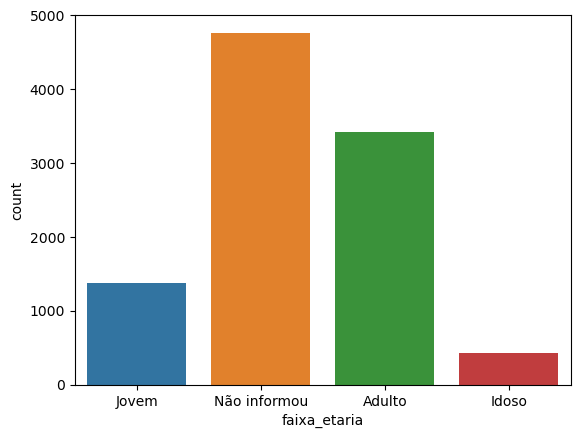

In [6]:
print('      Idades    ')
print('Idade media:', round(ads.age.mean(),1),'anos')
print('Idade minima:', ads.age.min(), 'anos')
print('Idade máxima:', ads.age.max(),'anos')
print('\n')
print('     Faixa etaria')
print(ads.faixa_etaria.value_counts())
sns.countplot(ads, x='faixa_etaria');

gender
Female        1834
Male          1810
Non-Binary    1663
Name: count, dtype: int64


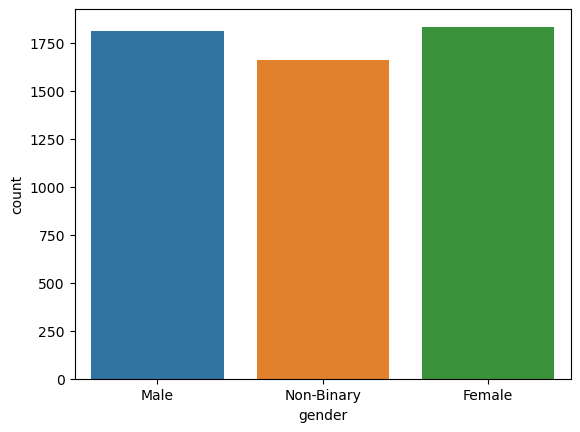

In [7]:
print(ads.gender.value_counts())
sns.countplot(ads, x='gender');

device_type
Desktop    2754
Mobile     2649
Tablet     2597
Name: count, dtype: int64


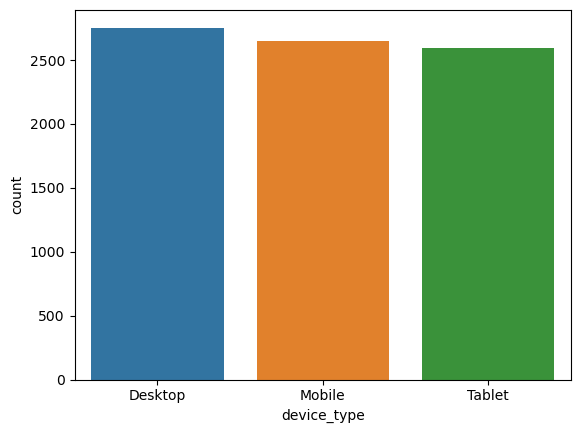

In [8]:
print(ads.device_type.value_counts())
sns.countplot(ads, x='device_type');

browsing_history
Entertainment    1175
Social Media     1054
Education        1029
Shopping          984
News              976
Name: count, dtype: int64


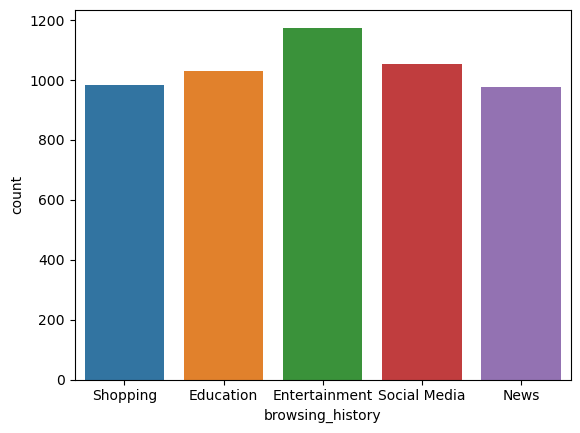

In [9]:
print(ads.browsing_history.value_counts())
sns.countplot(ads,x='browsing_history');

time_of_day
Morning      2126
Afternoon    2016
Evening      1958
Night        1900
Name: count, dtype: int64


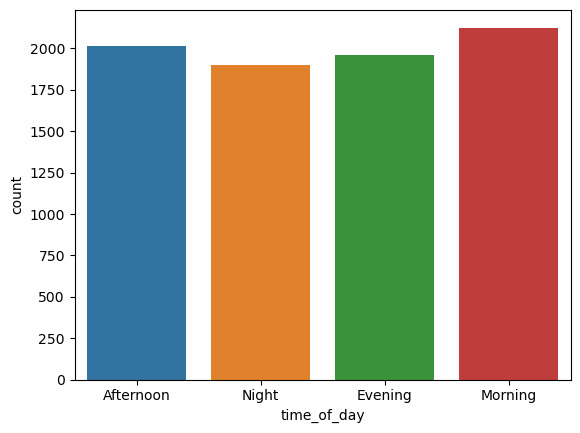

In [10]:
print(ads.time_of_day.value_counts())
sns.countplot(ads, x='time_of_day');

Quantidade de cliques:
click
1    6500
0    3500
Name: count, dtype: int64


Porcentagem de cliques:
click
1    65.0
0    35.0
Name: count, dtype: float64


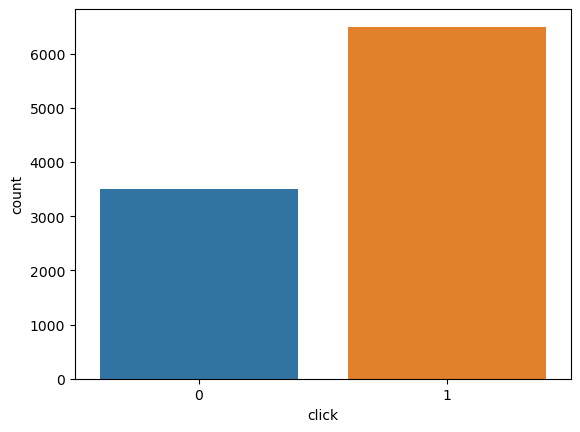

In [11]:
print('Quantidade de cliques:')
print(ads.click.value_counts())
print('\n')
print('Porcentagem de cliques:')
print(ads.click.value_counts()/ads.shape[0]*100)
sns.countplot(ads, x='click');

ad_position
Bottom    2817
Top       2597
Side      2586
Name: count, dtype: int64


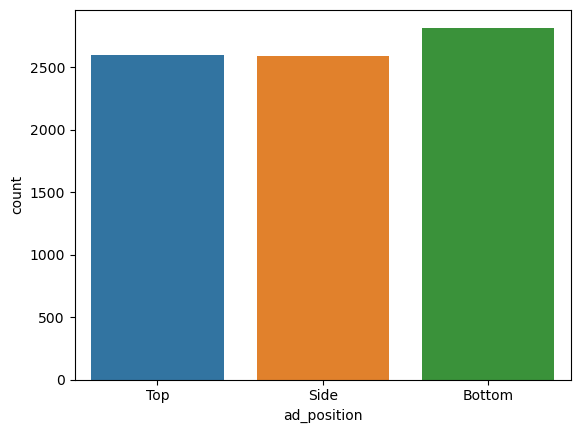

In [12]:
print(ads.ad_position.value_counts())
sns.countplot(ads, x='ad_position');

## Analise bivariada

In [13]:
ads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                10000 non-null  int64  
 1   full_name         10000 non-null  object 
 2   age               5234 non-null   float64
 3   gender            5307 non-null   object 
 4   device_type       8000 non-null   object 
 5   ad_position       8000 non-null   object 
 6   browsing_history  5218 non-null   object 
 7   time_of_day       8000 non-null   object 
 8   click             10000 non-null  int64  
 9   faixa_etaria      10000 non-null  object 
dtypes: float64(1), int64(2), object(7)
memory usage: 781.4+ KB


Media da idade por genero
gender
Female        40.207430
Male          39.568295
Non-Binary    40.871134
Name: age, dtype: float64


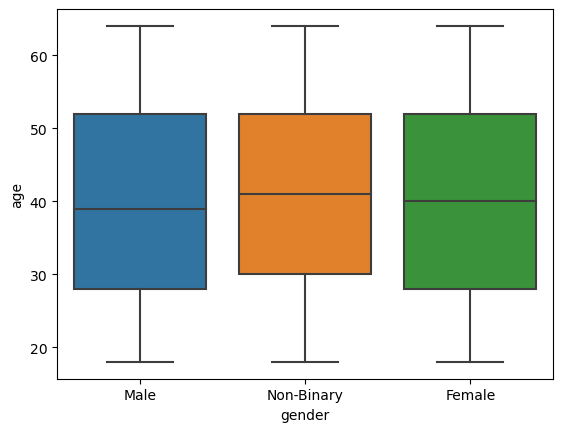

In [14]:
print('Media da idade por genero')
print(ads.groupby(['gender'])['age'].mean())
sns.boxplot(ads, x='gender', y='age');

Media da idade por click
click
0    41.634095
1    39.390033
Name: age, dtype: float64


Quantidades de click por faixa etaria
faixa_etaria  click
Adulto        0        1217
              1        2208
Idoso         0         209
              1         220
Jovem         0         457
              1         923
Não informou  0        1617
              1        3149
dtype: int64


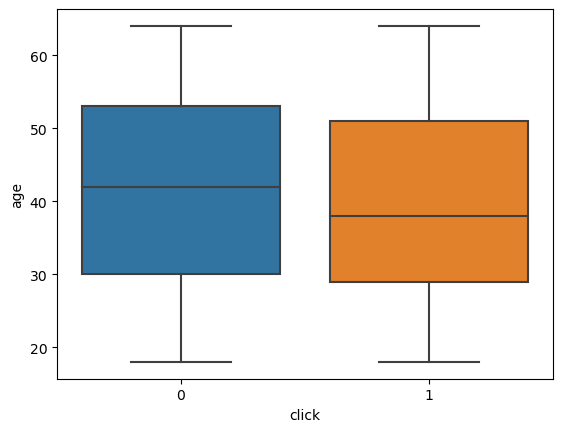

In [15]:
print('Media da idade por click')
print(ads.groupby('click')['age'].mean())
print('\n')
print('Quantidades de click por faixa etaria')
print(ads.groupby(['faixa_etaria', 'click']).size())
sns.boxplot(ads, x='click', y='age');

Quantidades de click por faixa etaria
gender      click
Female      0         628
            1        1206
Male        0         619
            1        1191
Non-Binary  0         611
            1        1052
dtype: int64


<Axes: xlabel='gender,click'>

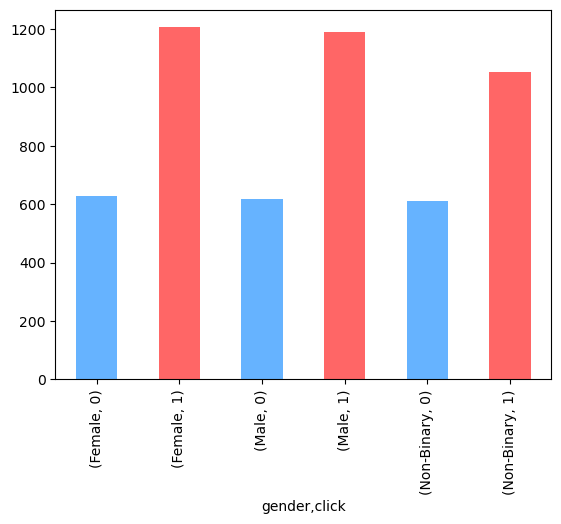

In [16]:
print('Quantidades de click por faixa etaria')
print(ads.groupby(['gender', 'click']).size())
ads.groupby(['gender', 'click']).size().plot(kind='bar', stacked=True, color=['#66b3ff', '#ff6666'])

Quantidades de click por faixa etaria
ad_position  click
Bottom       0         881
             1        1936
Side         0         953
             1        1633
Top          0         948
             1        1649
dtype: int64


<Axes: xlabel='ad_position,click'>

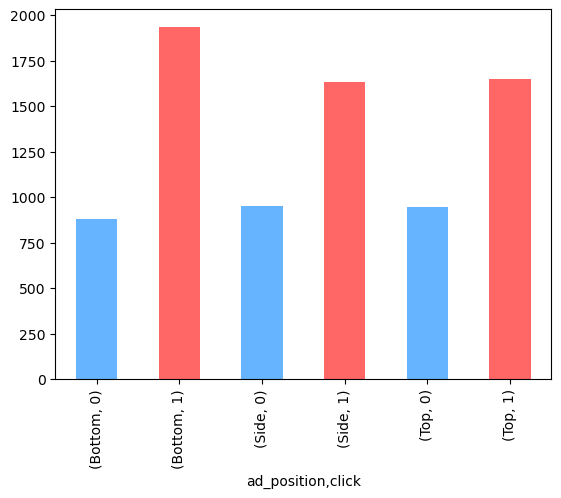

In [17]:
print('Quantidades de click por faixa etaria')
print(ads.groupby(['ad_position', 'click']).size())
ads.groupby(['ad_position', 'click']).size().plot(kind='bar', stacked=True, color=['#66b3ff', '#ff6666'])

Quantidades de click por faixa etaria
browsing_history  click
Education         0        383
                  1        646
Entertainment     0        367
                  1        808
News              0        399
                  1        577
Shopping          0        349
                  1        635
Social Media      0        384
                  1        670
dtype: int64


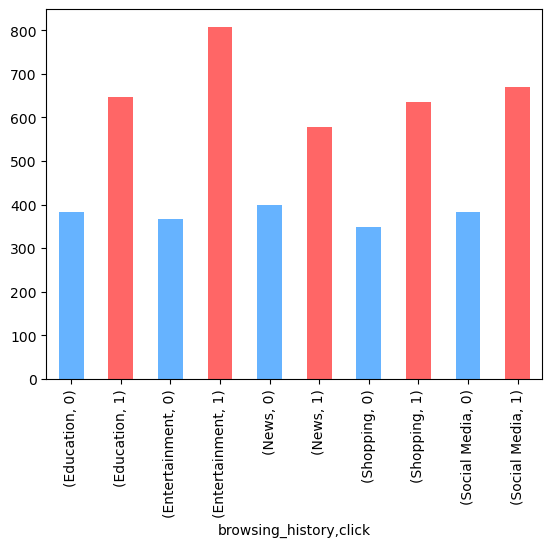

In [18]:
print('Quantidades de click por faixa etaria')
print(ads.groupby(['browsing_history', 'click']).size())
ads.groupby(['browsing_history', 'click']).size().plot(kind='bar', stacked=True, color=['#66b3ff', '#ff6666']);

Quantidades de click por faixa etaria
time_of_day  click
Afternoon    0         634
             1        1382
Evening      0         725
             1        1233
Morning      0         712
             1        1414
Night        0         713
             1        1187
dtype: int64


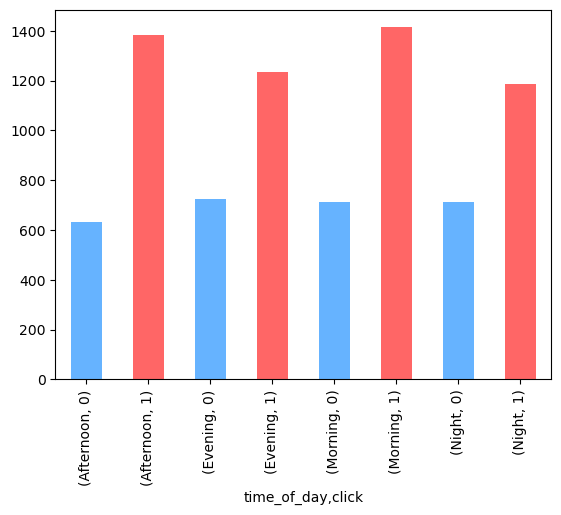

In [19]:
print('Quantidades de click por faixa etaria')
print(ads.groupby(['time_of_day', 'click']).size())
ads.groupby(['time_of_day', 'click']).size().plot(kind='bar', stacked=True, color=['#66b3ff', '#ff6666']);

In [20]:
ads.columns

Index(['id', 'full_name', 'age', 'gender', 'device_type', 'ad_position',
       'browsing_history', 'time_of_day', 'click', 'faixa_etaria'],
      dtype='object')

# Modelagem

## Tratamento dos dados

In [21]:
ads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                10000 non-null  int64  
 1   full_name         10000 non-null  object 
 2   age               5234 non-null   float64
 3   gender            5307 non-null   object 
 4   device_type       8000 non-null   object 
 5   ad_position       8000 non-null   object 
 6   browsing_history  5218 non-null   object 
 7   time_of_day       8000 non-null   object 
 8   click             10000 non-null  int64  
 9   faixa_etaria      10000 non-null  object 
dtypes: float64(1), int64(2), object(7)
memory usage: 781.4+ KB


In [22]:
# excluindo as colunas id e full_name
ads.drop(['id', 'full_name'], axis=1, inplace=True)

In [23]:
ads

,age,gender,device_type,ad_position,browsing_history,time_of_day,click,faixa_etaria
0,22.0,NaN,Desktop,Top,Shopping,Afternoon,1,Jovem
1,NaN,Male,Desktop,Top,NaN,NaN,1,Não informou
2,41.0,Non-Binary,NaN,Side,Education,Night,1,Adulto
3,34.0,Male,NaN,NaN,Entertainment,Evening,1,Adulto
4,39.0,Non-Binary,NaN,NaN,Social Media,Morning,0,Adulto
...,...,...,...,...,...,...,...,...
9995,NaN,NaN,Mobile,Top,Education,NaN,0,Não informou
9996,NaN,Female,Desktop,Bottom,Entertainment,NaN,0,Não informou
9997,NaN,Male,Mobile,Side,NaN,Morning,0,Não informou
9998,NaN,NaN,Desktop,NaN,Shopping,Morning,1,Não informou


In [24]:
x = ads.drop('click', axis=1)
y = ads.click

In [25]:
x.select_dtypes(object)

,gender,device_type,ad_position,browsing_history,time_of_day,faixa_etaria
0,NaN,Desktop,Top,Shopping,Afternoon,Jovem
1,Male,Desktop,Top,NaN,NaN,Não informou
2,Non-Binary,NaN,Side,Education,Night,Adulto
3,Male,NaN,NaN,Entertainment,Evening,Adulto
4,Non-Binary,NaN,NaN,Social Media,Morning,Adulto
...,...,...,...,...,...,...
9995,NaN,Mobile,Top,Education,NaN,Não informou
9996,Female,Desktop,Bottom,Entertainment,NaN,Não informou
9997,Male,Mobile,Side,NaN,Morning,Não informou
9998,NaN,Desktop,NaN,Shopping,Morning,Não informou


In [26]:
# transformando variaveis de object para category
for col in ['gender','device_type', 'ad_position','browsing_history','time_of_day', 'faixa_etaria']:
    x[col] = pd.Categorical(x[col])

In [27]:
x_treino, x_teste, y_treino, y_teste = train_test_split(x,y, test_size=0.2, random_state=123)

### XG boost

In [28]:
# Definindo os parâmetros para fazer o grid search
param_grid = {
    'max_depth': [20,30,40],
    'learning_rate': [0.05, 0.1, 0.3],
    'subsample': [0.8, 1, 2],
    'colsample_bytree': [0.3,0.5, 0.8],
    'n_estimators':[200, 300, 400]
}

# Criando o classificador XGB para o GridSearchCV
xgb_clf = xgb.XGBClassifier(enable_categorical = True)

# Aplicando o GridSearchCV
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, scoring='accuracy', cv=3, verbose=1)

# Treinando o grid search
grid_search.fit(x_treino, y_treino)

# Melhor combinação de parâmetros
print(f'Melhores Parâmetros: {grid_search.best_params_}')
print(f'Melhor score:{grid_search.best_score_}')

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Melhores Parâmetros: {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 30, 'n_estimators': 300, 'subsample': 1}
Melhor score:0.7447490856591162


In [29]:
modelo = xgb.XGBClassifier(colsample_bytree= 0.5, learning_rate= 0.1, max_depth= 30, n_estimators= 300, subsample= 1, enable_categorical = True)
modelo.fit(x_treino,y_treino)
modelo.score(x_teste, y_teste)

0.754

In [30]:
y_pred = modelo.predict(x_teste)
accuracy_score(y_true=y_teste, y_pred=y_pred)

0.754

In [31]:
print(classification_report(y_teste, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.45      0.56       707
           1       0.75      0.92      0.83      1293

    accuracy                           0.75      2000
   macro avg       0.75      0.69      0.70      2000
weighted avg       0.75      0.75      0.74      2000



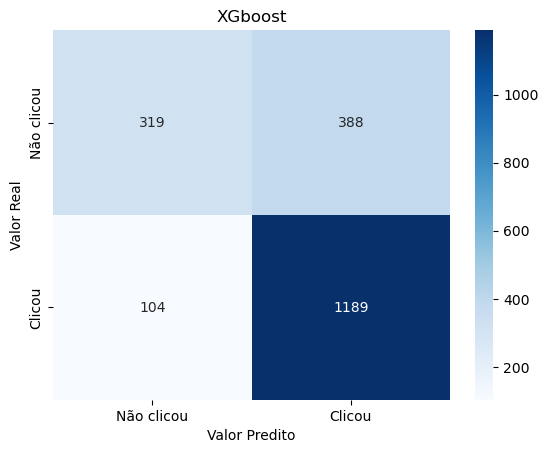

In [51]:
cm = confusion_matrix(y_teste, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Não clicou', 'Clicou'], yticklabels=['Não clicou', 'Clicou'])
plt.xlabel('Valor Predito')
plt.ylabel('Valor Real')
plt.title('XGboost');

### LightGBM

In [33]:
lgb = LGBMClassifier()
parametros = {
    'num_leaves':[30,50,40,100],
    'learning_rate':[0.05,0.1,0.2],
    'n_estimators':[100,200,300],
    'max_depth':[-1,10,20]
}

grid = GridSearchCV(estimator=lgb, param_grid=parametros, cv=5, scoring='accuracy', n_jobs=-1)

grid.fit(x_treino, y_treino)
print('Melhores parametros:', grid.best_params_)
print('Melhor score:', grid.best_score_)


[LightGBM] [Info] Number of positive: 5207, number of negative: 2793
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000103 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.650875 -> initscore=0.622888
[LightGBM] [Info] Start training from score 0.622888
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Melhores parametros: {'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 300, 'num_leaves': 50}
Melhor score: 0.757125


In [34]:
lgbm = LGBMClassifier(learning_rate= 0.2, max_depth= 10, n_estimators= 300, num_leaves= 50)
lgbm.fit(x_treino, y_treino)
lgbm.score(x_teste, y_teste)

[LightGBM] [Info] Number of positive: 5207, number of negative: 2793
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000103 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.650875 -> initscore=0.622888
[LightGBM] [Info] Start training from score 0.622888
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


0.758

In [35]:
y_pred_lgb = lgbm.predict(x_teste)

In [36]:
print(classification_report(y_teste, y_pred_lgb))

              precision    recall  f1-score   support

           0       0.73      0.49      0.59       707
           1       0.77      0.90      0.83      1293

    accuracy                           0.76      2000
   macro avg       0.75      0.70      0.71      2000
weighted avg       0.75      0.76      0.74      2000



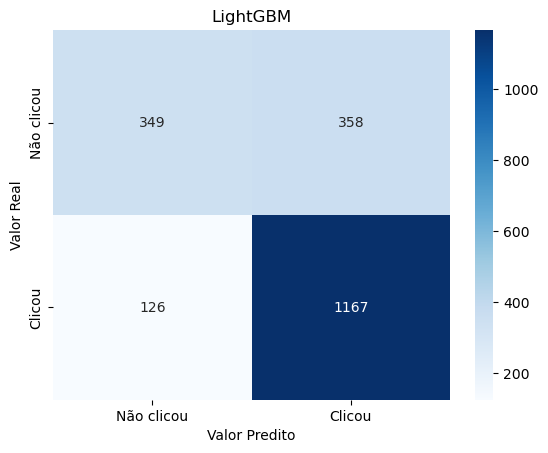

In [52]:
cm = confusion_matrix(y_teste, y_pred_lgb)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Não clicou', 'Clicou'], yticklabels=['Não clicou', 'Clicou'])
plt.xlabel('Valor Predito')
plt.ylabel('Valor Real')
plt.title('LightGBM');